In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import OrdinalEncoder
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor 
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from scipy import stats

In [2]:
#33 columns

#Path for file
path = "gs://<<<GCP BUCKET NAME>>>/Hospital_Inpatient_Discharges__SPARCS_De-Identified___2016.csv"


dtype = {"Health Service Area": "str",
         "Hospital County": "str",
         "Operating Certificate Number": "str",
         "Facility Id": "str",
         "Facility Name": "str",
         "Age Group": "str",
         "Zip Code - 3 digits": "str",
         "Gender": "str",
         "Race": "str",
         "Ethnicity": "str",
         "Type of Admission": "str",
         "Patient Disposition": "str",
         "Discharge Year": "int",
         "CCS Diagnosis Code": "int",
         "CCS Diagnosis Description": "str",
         "CCS Procedure Code": "int",
         "CCS Procedure Description": "str",
         "APR DRG Code": "int",
         "APR DRG Description": "str",
         "APR MDC Code": "int",
         "APR MDC Description": "str",
         "APR Severity of Illness Code": "int",
         "APR Severity of Illness Description": "str",
         "APR Risk of Mortality": "str",
         "APR Medical Surgical Description": "str",
         "Payment Typology 1": "str",
         "Payment Typology 2": "str",
         "Payment Typology 3": "str",
         "Birth Weight": "int",
         "Abortion Edit Indicator": "str",
         "Emergency Department Indicator": "str",
         }

cols = ["Length of Stay", "Type of Admission", "Age Group","Gender", "Race", "Ethnicity", "Facility Name",
        "APR DRG Description", "Total Charges", "Total Costs"]

In [3]:
df = pd.read_csv(path, usecols=cols, low_memory=False)

In [4]:
df.head()

,Facility Name,Age Group,Gender,Race,Ethnicity,Length of Stay,Type of Admission,APR DRG Description,Total Charges,Total Costs
0,Cuba Memorial Hospital Inc,70 or Older,F,White,Not Span/Hispanic,3,Urgent,Other pneumonia,"3,913.23","3,466.83"
1,Cuba Memorial Hospital Inc,30 to 49,M,White,Not Span/Hispanic,2,Elective,Other pneumonia,"3,597.1","3,746.8"
2,Cuba Memorial Hospital Inc,50 to 69,F,White,Not Span/Hispanic,7,Urgent,Chronic obstructive pulmonary disease,"9,149.22","8,322.1"
3,Cuba Memorial Hospital Inc,70 or Older,M,White,Not Span/Hispanic,4,Urgent,Other pneumonia,"5,880.61","5,828.87"
4,Cuba Memorial Hospital Inc,50 to 69,M,White,Not Span/Hispanic,5,Elective,Other pneumonia,"7,019.76","6,604"


In [5]:
#Removing column value's that produce a lot of outliers or because they do not relate to the end-visual.
df = df[df["Length of Stay"]!="120 +"]
df = df[df["Facility Name"] != "Redacted for Confidentiality"]
df = df[df["Gender"] != "U"]

#Filtering the df to only include the top 10 most common medical conditions
top_10 = df["APR DRG Description"].value_counts().nlargest(10)
top_10_df = pd.DataFrame(top_10)
top_10_list = top_10_df.index.to_list()

df = df[df["APR DRG Description"].isin(top_10_list)]

#Some data type cleaning
df["Length of Stay"] = df["Length of Stay"].astype(int)
df["Total Charges"] = df["Total Charges"].astype(str).str.replace(",", "").astype(float)
df["Daily Charges"] = df["Total Charges"] / df["Length of Stay"]
df.head()

,Facility Name,Age Group,Gender,Race,Ethnicity,Length of Stay,Type of Admission,APR DRG Description,Total Charges,Total Costs,Daily Charges
0,Cuba Memorial Hospital Inc,70 or Older,F,White,Not Span/Hispanic,3,Urgent,Other pneumonia,3913.23,"3,466.83",1304.410000
1,Cuba Memorial Hospital Inc,30 to 49,M,White,Not Span/Hispanic,2,Elective,Other pneumonia,3597.10,"3,746.8",1798.550000
2,Cuba Memorial Hospital Inc,50 to 69,F,White,Not Span/Hispanic,7,Urgent,Chronic obstructive pulmonary disease,9149.22,"8,322.1",1307.031429
3,Cuba Memorial Hospital Inc,70 or Older,M,White,Not Span/Hispanic,4,Urgent,Other pneumonia,5880.61,"5,828.87",1470.152500
4,Cuba Memorial Hospital Inc,50 to 69,M,White,Not Span/Hispanic,5,Elective,Other pneumonia,7019.76,"6,604",1403.952000


In [6]:
#Retaining only the age group, gender, medical condition, hospital name, and daily charge columns
df2 = df[["Age Group", "Gender", "APR DRG Description", "Facility Name",
          "Daily Charges"]]
df2

,Age Group,Gender,APR DRG Description,Facility Name,Daily Charges
0,70 or Older,F,Other pneumonia,Cuba Memorial Hospital Inc,1304.410000
1,30 to 49,M,Other pneumonia,Cuba Memorial Hospital Inc,1798.550000
2,50 to 69,F,Chronic obstructive pulmonary disease,Cuba Memorial Hospital Inc,1307.031429
3,70 or Older,M,Other pneumonia,Cuba Memorial Hospital Inc,1470.152500
4,50 to 69,M,Other pneumonia,Cuba Memorial Hospital Inc,1403.952000
...,...,...,...,...,...
2343415,70 or Older,F,Heart failure,St Catherine of Siena Hospital,9153.000000
2343416,30 to 49,F,Vaginal delivery,St Catherine of Siena Hospital,6978.500000
2343417,70 or Older,M,Septicemia & disseminated infections,St Catherine of Siena Hospital,25465.000000
2343419,70 or Older,M,Septicemia & disseminated infections,St Catherine of Siena Hospital,11692.500000


In [7]:
#Removing outliers from daily charges based on medical condition
final_df = pd.DataFrame()

for APR in df2["APR DRG Description"].unique():
    temp = df2[df2["APR DRG Description"] == APR]
    temp = temp[(np.abs(stats.zscore(temp["Daily Charges"])) < 3)]
    final_df = pd.concat([final_df, temp])
    
final_df

,Age Group,Gender,APR DRG Description,Facility Name,Daily Charges
0,70 or Older,F,Other pneumonia,Cuba Memorial Hospital Inc,1304.410000
1,30 to 49,M,Other pneumonia,Cuba Memorial Hospital Inc,1798.550000
3,70 or Older,M,Other pneumonia,Cuba Memorial Hospital Inc,1470.152500
4,50 to 69,M,Other pneumonia,Cuba Memorial Hospital Inc,1403.952000
6,50 to 69,M,Other pneumonia,Cuba Memorial Hospital Inc,1605.865000
...,...,...,...,...,...
2342849,30 to 49,M,Schizophrenia,St Catherine of Siena Hospital,4527.428571
2343077,30 to 49,M,Schizophrenia,St Catherine of Siena Hospital,4108.875000
2343171,50 to 69,F,Schizophrenia,St Catherine of Siena Hospital,4443.250000
2343238,50 to 69,F,Schizophrenia,St Catherine of Siena Hospital,4180.375000


In [8]:
#One hot encoding for categorical variables
categorical_cols = ["Age Group", "Gender", "APR DRG Description", "Facility Name"]

for col in categorical_cols:
    col_ohe = pd.get_dummies(final_df[col], prefix=col)
    final_df = pd.concat((final_df, col_ohe), axis=1).drop(col,axis=1)
    
final_df = final_df.dropna()
final_df

,Daily Charges,Age Group_0 to 17,Age Group_18 to 29,Age Group_30 to 49,Age Group_50 to 69,Age Group_70 or Older,Gender_F,Gender_M,APR DRG Description_Cellulitis & other skin infections,APR DRG Description_Cesarean delivery,...,Facility Name_Westfield Memorial Hospital Inc,Facility Name_White Plains Hospital Center,Facility Name_Winifred Masterson Burke Rehabilitation Hospital,Facility Name_Winthrop-University Hospital,Facility Name_Woman's Christian Association,Facility Name_Womans Christian Assoc Hospital - WCA Hosp at Jones Memorial Health Ce,Facility Name_Women And Children's Hospital Of Buffalo,Facility Name_Woodhull Medical & Mental Health Center,Facility Name_Wyckoff Heights Medical Center,Facility Name_Wyoming County Community Hospital
0,1304.410000,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1798.550000,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1470.152500,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1403.952000,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1605.865000,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2342849,4527.428571,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2343077,4108.875000,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2343171,4443.250000,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2343238,4180.375000,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
#Setting up train/test
X = np.array(final_df.loc[:, final_df.columns != "Daily Charges"])
y = np.array(final_df.loc[:, final_df.columns == "Daily Charges"]).ravel()

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=61)

In [10]:
#Finding optimal alpha for Ridge regression
cv_scores_ridge = []
alphas_ridge = []

i = 0.00000001
while i<10:
    ridge=Ridge(alpha=i, normalize=False)
    
    score = cross_val_score(ridge, X, y, cv=5, scoring="neg_mean_squared_error", error_score="raise")
    score = -np.mean(score)
    
    cv_scores_ridge.append(np.mean(score))
    alphas_ridge.append(i)
    
    i*=10

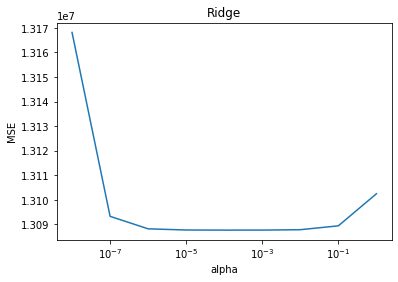

In [11]:
#Ridge regression's MSE as a function of alpha
plt.plot(alphas_ridge, cv_scores_ridge)
plt.semilogx()
plt.xlabel("alpha")
plt.ylabel("MSE")
plt.title("Ridge")
plt.show()

In [12]:
#Ridge regression's MAPE (using optimal alpha)
cv_scores_ridge = np.array(cv_scores_ridge)
best_alpha_ridge = alphas_ridge[np.argsort(cv_scores_ridge)[0]]

best_ridge = Ridge(alpha=best_alpha_ridge, normalize=False).fit(x_train, y_train)
y_ridge = best_ridge.predict(x_test)

MAPE_ridge = np.mean(np.abs((y_test - y_ridge)) / y_test) * 100
print("MAPE for Ridge:", MAPE_ridge)

MAPE for Ridge: 39.22639550466045


In [13]:
#Linear regression's MAPE 
LR = LinearRegression().fit(x_train, y_train)
y_LR = LR.predict(x_test)

MAPE_LR = np.mean(np.abs((y_test - y_LR)) / y_test)*100
print("MAPE for Linear Regression:", MAPE_LR)

MAPE for Linear Regression: 39.232632342566006


In [14]:
from google.cloud import storage
import os

In [15]:
coefs = pd.DataFrame({"Features": final_df.loc[:, final_df.columns != "Daily Charges"].columns,
                     "Coefficients": best_ridge.coef_.tolist()})

intercept = pd.DataFrame({"Features": ["intercept"], "Coefficients": [best_ridge.intercept_]})
coefs = pd.concat([coefs, intercept], ignore_index=True)

In [16]:
data = coefs
data["Placeholder"] = 0
data = data[["Placeholder", "Features", "Coefficients"]]
data

,Placeholder,Features,Coefficients
0,0,Age Group_0 to 17,-386.450175
1,0,Age Group_18 to 29,218.973396
2,0,Age Group_30 to 49,267.358078
3,0,Age Group_50 to 69,191.054150
4,0,Age Group_70 or Older,-290.831115
...,...,...,...
220,0,Facility Name_Women And Children's Hospital Of...,-397.610995
221,0,Facility Name_Woodhull Medical & Mental Health...,-427.922721
222,0,Facility Name_Wyckoff Heights Medical Center,-651.799241
223,0,Facility Name_Wyoming County Community Hospital,-2938.264062


In [17]:
#set up Age_group for merge,reformat the column and input for viz import
coef1=data.loc[data["Features"].str.contains("Age Group")]
coef1["merged"]=1
coef1["Features"]=[i.split("_")[1] for i in coef1["Features"]]
coef1=coef1.rename(columns={"Features":"Age_group"})
coef1

/opt/conda/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Placeholder,Age_group,Coefficients,merged
0,0,0 to 17,-386.450175,1
1,0,18 to 29,218.973396,1
2,0,30 to 49,267.358078,1
3,0,50 to 69,191.054150,1
4,0,70 or Older,-290.831115,1


In [18]:
#set up APR for merge,reformat the column and input for viz import
coefapr=data.loc[data["Features"].str.contains("APR")]
coefapr["Features"]=[i.split("_")[1] for i in coefapr["Features"]]
coefapr=coefapr.rename(columns={"Features":"APR"})
coefapr["merged"]=1
coefapr

/opt/conda/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Placeholder,APR,Coefficients,merged
7,0,Cellulitis & other skin infections,-988.269648,1
8,0,Cesarean delivery,-735.310971,1
9,0,Chronic obstructive pulmonary disease,-76.533396,1
10,0,Heart failure,29.670888,1
11,0,Knee joint replacement,11859.209402,1
12,0,"Neonate birthwt >2499g, normal newborn or neon...",-4258.133965,1
13,0,Other pneumonia,-196.212576,1
14,0,Schizophrenia,-4763.129758,1
15,0,Septicemia & disseminated infections,368.687463,1
16,0,Vaginal delivery,-1240.064395,1


In [19]:
#set up Gender for merge,reformat the column and input for viz import
coefgen=data.loc[data["Features"].str.contains("Gender")]
coefgen["Features"]=[i.split("_")[1] for i in coefgen["Features"]]
coefgen=coefgen.rename(columns={"Features":"Gender"})
coefgen["merged"]=1
coefgen



/opt/conda/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Placeholder,Gender,Coefficients,merged
5,0,F,-114.666286,1
6,0,M,114.668361,1


In [20]:
#set up Hospitals for merge,reformat the column and input for viz import
coeffac=data.loc[data["Features"].str.contains("Facility")]
coeffac["Features"]=[i.split("_")[1] for i in coeffac["Features"]]
coeffac=coeffac.rename(columns={"Features":"Facility"})
coeffac["merged"]=1
coeffac

/opt/conda/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Placeholder,Facility,Coefficients,merged
17,0,Adirondack Medical Center-Saranac Lake Site,-1165.797280,1
18,0,Albany Medical Center Hospital,47.794810,1
19,0,Albany Memorial Hospital,-2163.625600,1
20,0,Alice Hyde Medical Center,-1675.977616,1
21,0,Arnot Ogden Medical Center,-1935.414156,1
...,...,...,...,...
219,0,Womans Christian Assoc Hospital - WCA Hosp at ...,-978.586177,1
220,0,Women And Children's Hospital Of Buffalo,-397.610995,1
221,0,Woodhull Medical & Mental Health Center,-427.922721,1
222,0,Wyckoff Heights Medical Center,-651.799241,1


In [21]:
#merging coefficient tables
merge1=coef1.merge(coeffac,on="merged",how="outer")
merge2=merge1.merge(coefgen,on="merged",how="outer")
merged4=merge2.merge(coefapr,on="merged",how="outer")
merged4

,Placeholder_x,Age_group,Coefficients_x,merged,Placeholder_y,Facility,Coefficients_y,Placeholder_x,Gender,Coefficients_x,Placeholder_y,APR,Coefficients_y
0,0,0 to 17,-386.450175,1,0,Adirondack Medical Center-Saranac Lake Site,-1165.797280,0,F,-114.666286,0,Cellulitis & other skin infections,-988.269648
1,0,0 to 17,-386.450175,1,0,Adirondack Medical Center-Saranac Lake Site,-1165.797280,0,F,-114.666286,0,Cesarean delivery,-735.310971
2,0,0 to 17,-386.450175,1,0,Adirondack Medical Center-Saranac Lake Site,-1165.797280,0,F,-114.666286,0,Chronic obstructive pulmonary disease,-76.533396
3,0,0 to 17,-386.450175,1,0,Adirondack Medical Center-Saranac Lake Site,-1165.797280,0,F,-114.666286,0,Heart failure,29.670888
4,0,0 to 17,-386.450175,1,0,Adirondack Medical Center-Saranac Lake Site,-1165.797280,0,F,-114.666286,0,Knee joint replacement,11859.209402
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20695,0,70 or Older,-290.831115,1,0,Wyoming County Community Hospital,-2938.264062,0,M,114.668361,0,"Neonate birthwt >2499g, normal newborn or neon...",-4258.133965
20696,0,70 or Older,-290.831115,1,0,Wyoming County Community Hospital,-2938.264062,0,M,114.668361,0,Other pneumonia,-196.212576
20697,0,70 or Older,-290.831115,1,0,Wyoming County Community Hospital,-2938.264062,0,M,114.668361,0,Schizophrenia,-4763.129758
20698,0,70 or Older,-290.831115,1,0,Wyoming County Community Hospital,-2938.264062,0,M,114.668361,0,Septicemia & disseminated infections,368.687463


In [22]:
#cleaning the table
ridgecoef=merged4.iloc[:,[1,2,5,6,8,9,11,12]]
ridgecoef

,Age_group,Coefficients_x,Facility,Coefficients_y,Gender,Coefficients_x,APR,Coefficients_y
0,0 to 17,-386.450175,Adirondack Medical Center-Saranac Lake Site,-1165.797280,F,-114.666286,Cellulitis & other skin infections,-988.269648
1,0 to 17,-386.450175,Adirondack Medical Center-Saranac Lake Site,-1165.797280,F,-114.666286,Cesarean delivery,-735.310971
2,0 to 17,-386.450175,Adirondack Medical Center-Saranac Lake Site,-1165.797280,F,-114.666286,Chronic obstructive pulmonary disease,-76.533396
3,0 to 17,-386.450175,Adirondack Medical Center-Saranac Lake Site,-1165.797280,F,-114.666286,Heart failure,29.670888
4,0 to 17,-386.450175,Adirondack Medical Center-Saranac Lake Site,-1165.797280,F,-114.666286,Knee joint replacement,11859.209402
...,...,...,...,...,...,...,...,...
20695,70 or Older,-290.831115,Wyoming County Community Hospital,-2938.264062,M,114.668361,"Neonate birthwt >2499g, normal newborn or neon...",-4258.133965
20696,70 or Older,-290.831115,Wyoming County Community Hospital,-2938.264062,M,114.668361,Other pneumonia,-196.212576
20697,70 or Older,-290.831115,Wyoming County Community Hospital,-2938.264062,M,114.668361,Schizophrenia,-4763.129758
20698,70 or Older,-290.831115,Wyoming County Community Hospital,-2938.264062,M,114.668361,Septicemia & disseminated infections,368.687463


In [23]:
ridgecoef["beta"]=best_ridge.intercept_
ridgecoef

/opt/conda/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Age_group,Coefficients_x,Facility,Coefficients_y,Gender,Coefficients_x,APR,Coefficients_y,beta
0,0 to 17,-386.450175,Adirondack Medical Center-Saranac Lake Site,-1165.797280,F,-114.666286,Cellulitis & other skin infections,-988.269648,6717.44943
1,0 to 17,-386.450175,Adirondack Medical Center-Saranac Lake Site,-1165.797280,F,-114.666286,Cesarean delivery,-735.310971,6717.44943
2,0 to 17,-386.450175,Adirondack Medical Center-Saranac Lake Site,-1165.797280,F,-114.666286,Chronic obstructive pulmonary disease,-76.533396,6717.44943
3,0 to 17,-386.450175,Adirondack Medical Center-Saranac Lake Site,-1165.797280,F,-114.666286,Heart failure,29.670888,6717.44943
4,0 to 17,-386.450175,Adirondack Medical Center-Saranac Lake Site,-1165.797280,F,-114.666286,Knee joint replacement,11859.209402,6717.44943
...,...,...,...,...,...,...,...,...,...
20695,70 or Older,-290.831115,Wyoming County Community Hospital,-2938.264062,M,114.668361,"Neonate birthwt >2499g, normal newborn or neon...",-4258.133965,6717.44943
20696,70 or Older,-290.831115,Wyoming County Community Hospital,-2938.264062,M,114.668361,Other pneumonia,-196.212576,6717.44943
20697,70 or Older,-290.831115,Wyoming County Community Hospital,-2938.264062,M,114.668361,Schizophrenia,-4763.129758,6717.44943
20698,70 or Older,-290.831115,Wyoming County Community Hospital,-2938.264062,M,114.668361,Septicemia & disseminated infections,368.687463,6717.44943


In [24]:
#Calculating the prediction value by by ridge regression)
ridgecoef["Predict"]=ridgecoef.iloc[:,1]+ridgecoef.iloc[:,3]+ridgecoef.iloc[:,5]\
                        +ridgecoef.iloc[:,7]\
                        +ridgecoef.iloc[:,8]

/opt/conda/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [25]:
#Cleaning up coefficients 
ridgecoef1=ridgecoef.iloc[:,[0,2,4,6,9]]
ridgecoef1

,Age_group,Facility,Gender,APR,Predict
0,0 to 17,Adirondack Medical Center-Saranac Lake Site,F,Cellulitis & other skin infections,4062.266040
1,0 to 17,Adirondack Medical Center-Saranac Lake Site,F,Cesarean delivery,4315.224717
2,0 to 17,Adirondack Medical Center-Saranac Lake Site,F,Chronic obstructive pulmonary disease,4974.002292
3,0 to 17,Adirondack Medical Center-Saranac Lake Site,F,Heart failure,5080.206576
4,0 to 17,Adirondack Medical Center-Saranac Lake Site,F,Knee joint replacement,16909.745090
...,...,...,...,...,...
20695,70 or Older,Wyoming County Community Hospital,M,"Neonate birthwt >2499g, normal newborn or neon...",-655.111350
20696,70 or Older,Wyoming County Community Hospital,M,Other pneumonia,3406.810039
20697,70 or Older,Wyoming County Community Hospital,M,Schizophrenia,-1160.107143
20698,70 or Older,Wyoming County Community Hospital,M,Septicemia & disseminated infections,3971.710077


In [26]:
#path = "gs://sparcs_regression/Hospital_Inpatient_Discharges__SPARCS_De-Identified___2016.csv"
path2 = "gs://sparcs_regression/County.csv"
county = pd.read_csv(path2, header=0,low_memory=False)
county=county.dropna(axis=0, subset=['County'])
county.head()

,Facility,County,Zip,Beds,Ownership,2016 Discharges,2016 Charges,2016 Costs
0,Albany Medical Center - South Clinical Campus,Albany,12208.0,NaN,Not for Profit Corporation,8,"$150,158.00","$58,209.00"
1,Albany Medical Center Hospital,Albany,12208.0,631.0,Not for Profit Corporation,"38,988","$1,938,837,415.00","$607,897,923.00"
2,Albany Memorial Hospital,Albany,12204.0,165.0,Not for Profit Corporation,"2,537","$53,516,458.00","$25,034,084.00"
3,St Peters Hospital,Albany,12208.0,803.0,Not for Profit Corporation,"27,743","$979,676,933.00","$320,864,607.00"
4,St. Peter's Addiction Recovery Center,Albany,12084.0,NaN,Not for Profit Corporation,497,"$6,256,591.00","$3,430,207.00"


In [27]:
ridgepredict=ridgecoef1.merge(county, on="Facility",how="left")

In [28]:
#making sure every hospital having county info
ridgepredict[ridgepredict["County"].isnull()]

,Age_group,Facility,Gender,APR,Predict,County,Zip,Beds,Ownership,2016 Discharges,2016 Charges,2016 Costs


In [29]:
#Saving output in csv format into <<<GCP BUCKET NAME>>>
client = storage.Client()
bucket = client.get_bucket("<<<GCP BUCKET NAME>>>")

bucket.blob("predict.csv").upload_from_string(ridgepredict.to_csv(), "text/csv")